# Проект: классификация

In [674]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [675]:
df = pd.read_csv('bank_fin.csv', sep = ';')

In [676]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


Как видно, пропуски есть только в признаке 'balance', пропущено 25 значений

### Задание 2

In [677]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

В признаке 'job' есть значение 'unknown', которое по сути является пропуском

### Задание 3

In [678]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].astype('str').apply(lambda x: x.replace(' ', '').replace('$', '').replace(',', '.')).astype('float')
round(df['balance'].median(), 3)

550.0

### Задание 4

In [679]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df.fillna(value={'balance': df['balance'].median()}, inplace=True)
round(df['balance'].mean(), 3)

1526.936

### Задание 5

In [680]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
features = ['education', 'job'] # признаки, в которых необходимо заменить пропущенное значение на модальное
for feature in features:
    moda = df[feature].mode()[0] # находим моду признака
    df[feature] = df[feature].apply(lambda x: moda if x=='unknown' else x) # заменяем 'unknown' на моду

### Задание 6

In [681]:
# удалите все выбросы для признака balance
# воспользуемся методом межквартильного размаха
iqr = np.percentile(df['balance'], 75) - np.percentile(df['balance'], 25) # находим IQR
lower_bound = np.percentile(df['balance'], 25) - (iqr*1.5) # находим нижнюю границу
upper_bound = np.percentile(df['balance'], 75) + (iqr*1.5) # находим верхнюю границу
print(f'Нижняя граница - {round(lower_bound)}')
print(f'Верхняя граница - {round(upper_bound)}')
data = df.copy()
df = df[df['balance']<=upper_bound]
df = df[df['balance']>=lower_bound]
print(f'Результирующее число записей: {df.shape[0]}')

Нижняя граница - -2241
Верхняя граница - 4063
Результирующее число записей: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

no     54.0
yes    46.0
Name: deposit, dtype: float64

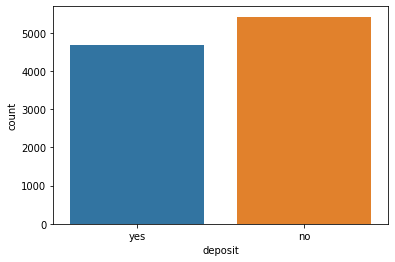

In [682]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
sns.countplot(df['deposit'])
round((df['deposit'].value_counts() / df.shape[0]) * 100) # выведем в процентном соотношении 

Как видно из диаграммы, классы сбалансированы, доля клиентов открывших депозит составляет 46%, против 54% не открывших

### Задания 2 и 3

In [683]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df.describe() # посмотрим описательные статитстики для количественных признаков

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


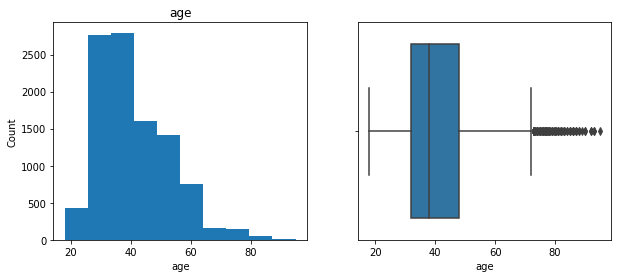

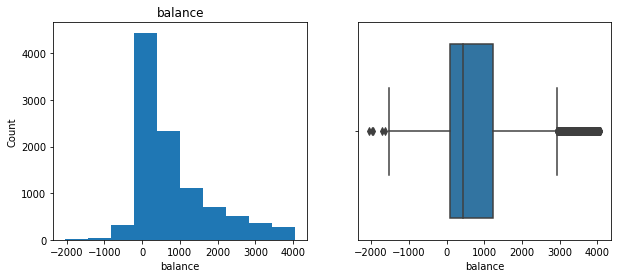

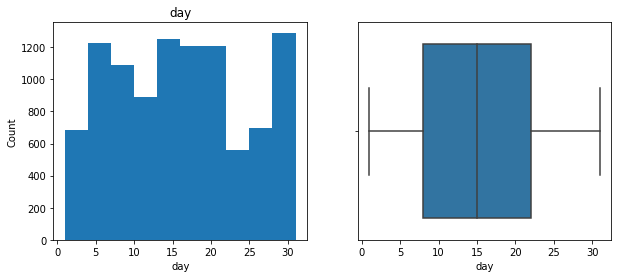

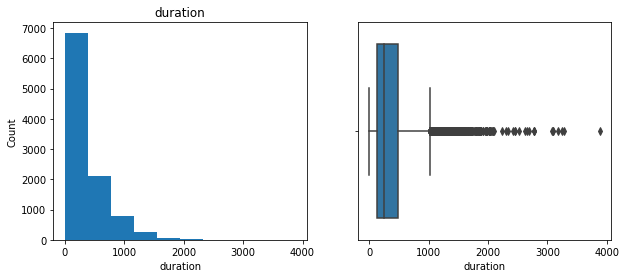

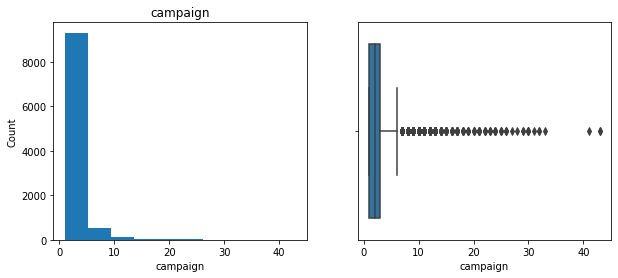

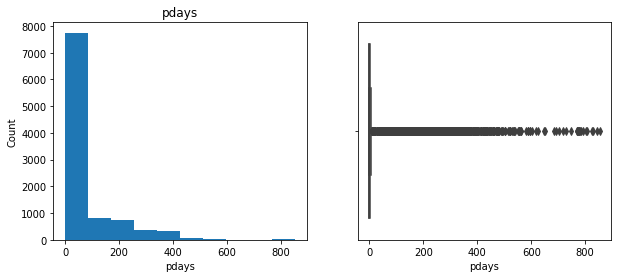

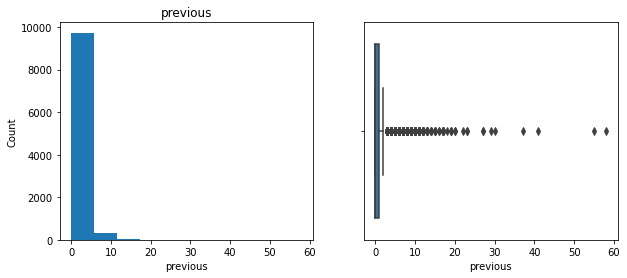

In [684]:
types = df.dtypes
count_features = list(types[(types != 'object')].index) # выделили все количественные переменные
cat_features = list(types[(types == 'object')].index) #выделили все категориальные переменные

for feature in count_features: # построим гистограмму и ящик с усами для каждого признака
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    ax1.hist(df[feature])
    ax1.set(title=feature, xlabel=feature, ylabel='Count')
    ax2 = sns.boxplot(df[feature])
    ax2.set(xlabel=feature)
    plt.show()

<AxesSubplot:>

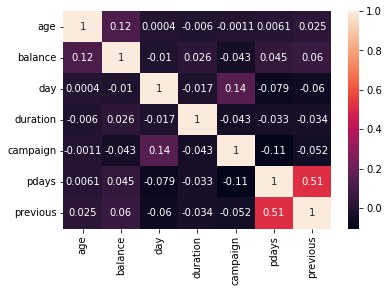

In [685]:
sns.heatmap(df.corr(), annot=True) # посмотрим как эти признаки между собой коррелируют

Приведенная статистика показывает, что:
    
1. Данные признаки не коррелируют между собой
    
2. Наблюдаются выбросы практически по всем признакам, кроме признака 'day'. Так в признаке 'age' присутствуют выбросы справа, в признаке 'balance' и справа (очень большой баланс) и слева (отрицательный баланс). У остальных количественных признаков очень неравномерное распределение

### Задания 4 и 5

In [686]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#постройте визуализации, иллюстрирующие результаты
df[cat_features].describe()

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


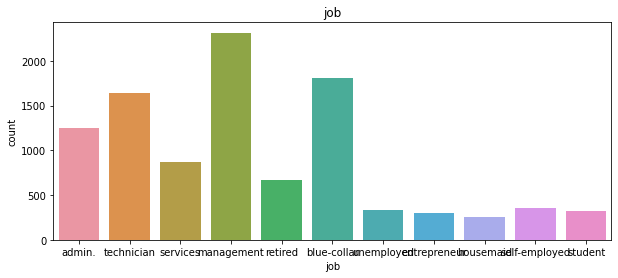

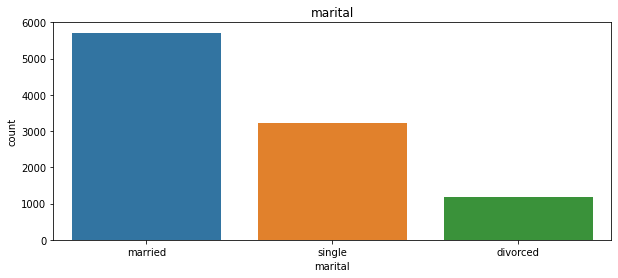

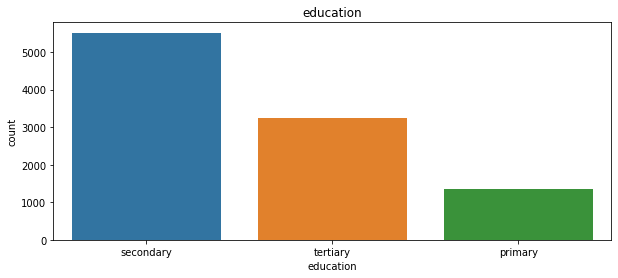

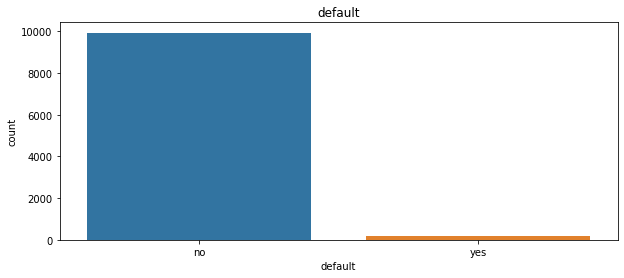

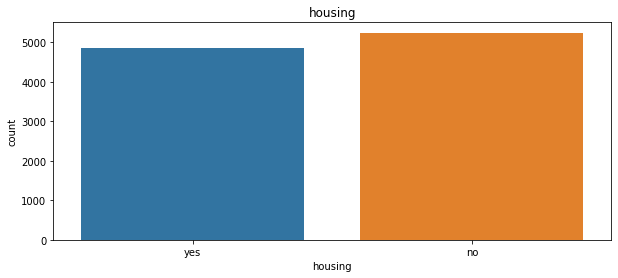

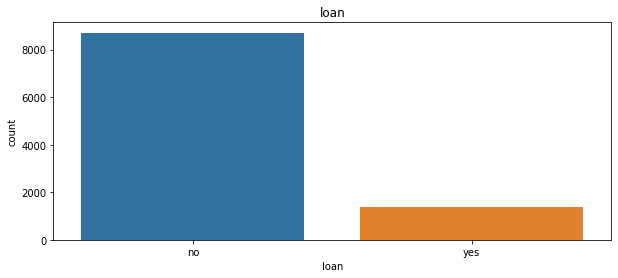

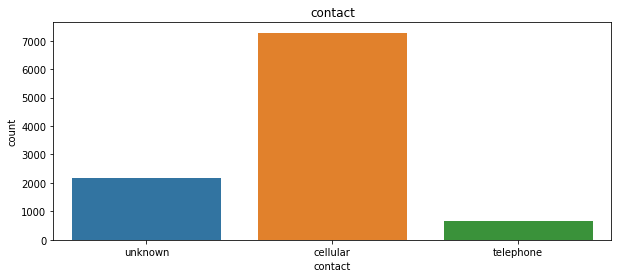

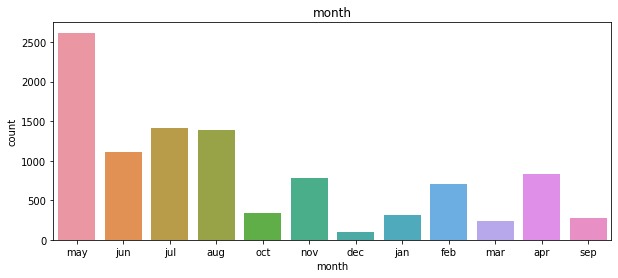

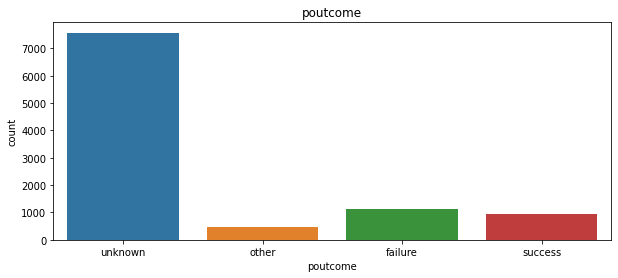

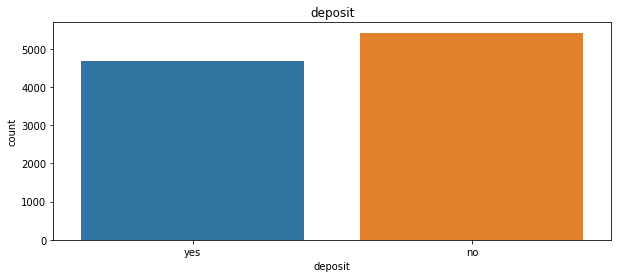

In [687]:
for feature in cat_features: # построим countplot для каждой категориальной переменной
    fig, ax  = plt.subplots(1, 1, figsize=(10,4))
    ax = sns.countplot(df[feature])
    ax.set(title=feature)
    plt.show()

Сфера занятости представлена 11 позициями, самое распространненное - management.

В текущей маркетинговой компании работа с клиентами велась каждый месяц, в лидерах по контактам май, декабрь самый непродуктивный по контактам.

Образование представлено тремя позициями, самое распространенное - secondary.

Семейное положение также предствлено тремя позициями, самое распростарненное - married.

Есть небольшое количество людей с просроченным кредитом.

У чуть больше чем половины клиентов есть кредит на жилье, у небольшого процента - есть кредит на личные нужды.

### Задание 6

<AxesSubplot:xlabel='poutcome', ylabel='count'>

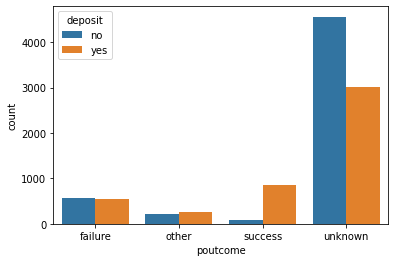

In [688]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
df1 = df.groupby(by=['poutcome', 'deposit'], as_index=False).count()[['poutcome', 'deposit', 'age']].rename(columns={'age': 'count'})
sns.barplot(data=df1, x='poutcome', y='count', hue='deposit')

Наглядно видно, что для статуса 'success' предыдущей компании успех в текущей компании превалирует над количеством неудач 

### Задание 7

<AxesSubplot:xlabel='month', ylabel='count'>

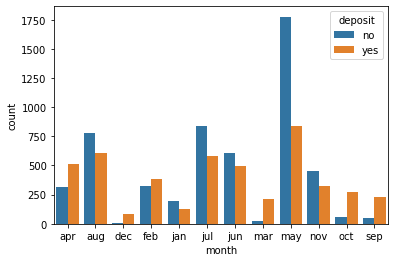

In [689]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
df2 = df.groupby(by=['month', 'deposit'], as_index=False).count()[['month', 'deposit', 'age']].rename(columns={'age': 'count'})
sns.barplot(data=df2, x='month', y='count', hue='deposit')

Как видно из диаграммы, в мае месяце от предложения открыть депозит отказалось наибольшее количество клиентов, но данный месяц является рекордным и по открытым депозитам. В мае зафиксировано очень большое количество контактов с клиентами в принципе.

### Задание 8

<AxesSubplot:xlabel='age_group', ylabel='count'>

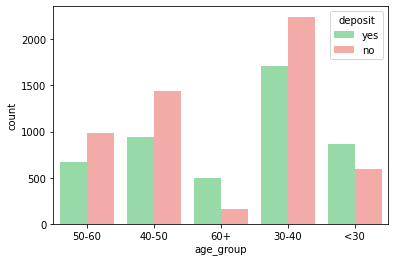

In [690]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def check_age_group(age): # функция для разбиения возраста по категориям
    if age < 30: return '<30'
    elif age < 40: return '30-40'
    elif age < 50: return '40-50'
    elif age < 60: return '50-60'
    else: return '60+'

df['age_group'] = df['age'].apply(check_age_group) # создаем столбец с категорией возраста
sns.countplot(data=df, x='age_group', hue='deposit', palette={'yes': '#8de5a1', 'no': '#ff9f9b'}) # визуализируем

В возрастных группах '<30' и '60+' люди более склонны открывать депозит, чем отказываться от него

### Задания 9 и 10

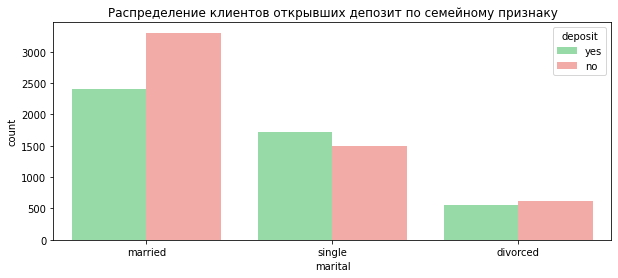

In [691]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
fig, ax = plt.subplots(figsize=(10,4))
plt.title('Распределение клиентов открывших депозит по семейному признаку')
ax = sns.countplot(data=df, x='marital', hue='deposit', palette={'yes': '#8de5a1', 'no': '#ff9f9b'})

Среди одиноких людей преобладает количество клиентов открывших депозит. В других группах данного признака наблюдается обратная тенденция.
Но наибольшее количество депозитов открыто в группе - married, кроме того она самая многочисленная

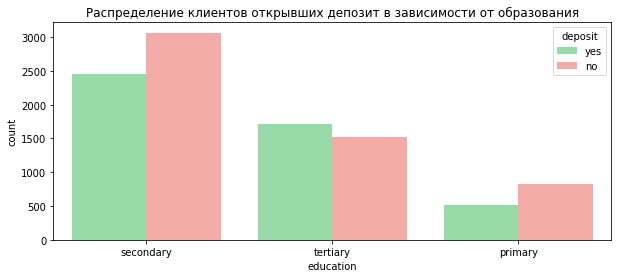

In [692]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
fig, ax = plt.subplots(figsize=(10,4))
plt.title('Распределение клиентов открывших депозит в зависимости от образования')
ax = sns.countplot(data=df, x='education', hue='deposit', palette={'yes': '#8de5a1', 'no': '#ff9f9b'})

Самое большое количество клиентов, открывших депозит, имеют среднее образование, но это и самая многочисленная группа в данной выборке, количество не открывших депозит в этой категории все таки больше. В тоже время, среди клиентов с высшим образованием преобладают те, кто депозит открыл.

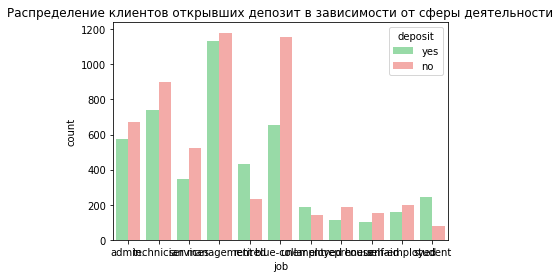

In [693]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятостиfig, ax = plt.subplots(figsize=(15,5))
plt.title('Распределение клиентов открывших депозит в зависимости от сферы деятельности')
ax = sns.countplot(data=df, x='job', hue='deposit', palette={'yes': '#8de5a1', 'no': '#ff9f9b'})

Наибольшее число клиентов относятся к сфере деятельности - management, в этой же группе и наибольшее количество открытых депозитов

### Задание 11

In [694]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
pivot_yes = df[df['deposit']=='yes'].pivot_table(values='deposit', index='education', columns='marital', aggfunc='count')
pivot_no = df[df['deposit']=='no'].pivot_table(values='deposit', index='education', columns='marital', aggfunc='count')
pivot_yes

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


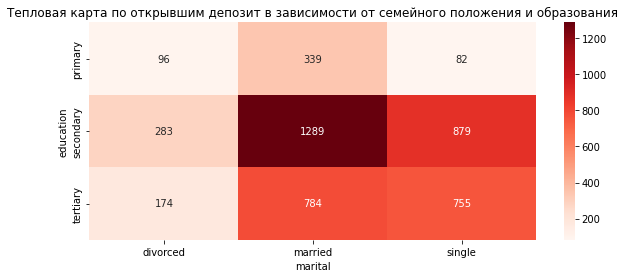

In [695]:
fiп, ax = plt.subplots(figsize=(10,4))
plt.title('Тепловая карта по открывшим депозит в зависимости от семейного положения и образования')
ax = sns.heatmap(pivot_yes, annot=True, fmt='d', cmap='Reds')

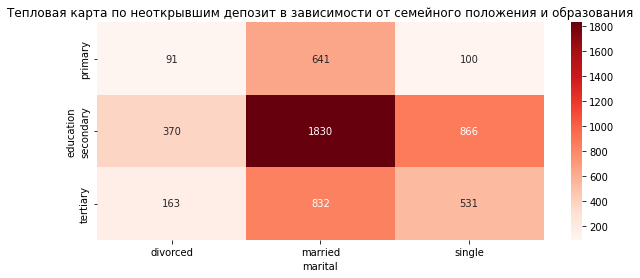

In [696]:
fiп, ax = plt.subplots(figsize=(10,4))
plt.title('Тепловая карта по неоткрывшим депозит в зависимости от семейного положения и образования')
ax = sns.heatmap(pivot_no, annot=True, fmt='d', cmap='Reds')

Клиенты с образованием 'secondary' и семейным положением 'married' являются самой многочисленной группой среди тех, кто открыл депозит. Среди не открывших депозит - это также наиболее многочисленная группа, причем неоткрывших больше чем открывших.

## Часть 3: преобразование данных

### Задание 1

In [697]:
# преобразуйте уровни образования
# учим и сразу применяем кодирование к признаку education, результат переводим в список
le = LabelEncoder()
data_le = le.fit_transform(df['education']).tolist() 

df['education'] = data_le # записываем полученные значения в признак education_
df['education'].sum()

11995

In [698]:
# поступим аналогично с признаком age_group, созданным чуть ранее
le = LabelEncoder()
data_le = le.fit_transform(df['age_group']).tolist() 

df['age_group'] = data_le

### Задания 2 и 3

In [699]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df['deposit'] = df['deposit'].apply(lambda x: 0 if x=='no' else 1) # закодируем переменную, no - 0, yes - 1
round(df['deposit'].std(), 3) # найдем стандартное отклонение округленное до 3 единиц после запятой

0.499

In [700]:
# преобразуем бинарные переменные в представление из нулей и единиц и посчитаем сумму средних арифметических
bin_feature = ['default', 'housing', 'loan'] # создали список из бинарных признаков
summa = 0

for feature in bin_feature:
    df[feature] = df[feature].apply(lambda x: 0 if x=='no' else 1)
    summa += df[feature].mean()
round(summa, 3) # находим сумму средних арифметических по трем преобразованным признакам

0.635

### Задание 4

In [701]:
# создайте дамми-переменные
df = pd.get_dummies(df, columns=['job', 'marital', 'contact', 'month', 'poutcome'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int64  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_group          10105 non-null  int64  
 13  job_admin.         10105 non-null  uint8  
 14  job_blue-collar    10105 non-null  uint8  
 15  job_entrepreneur   10105 non-null  uint8  
 16  job_housemaid      101

### Задания 5 и 6

In [702]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
df.corr()

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
age,1.000000,-0.191124,-0.009929,0.115164,-0.164196,-0.026357,0.000396,-0.006007,-0.001143,0.006107,...,0.009769,0.024785,-0.119656,0.026875,0.056998,0.036352,0.001994,-0.020942,0.060009,-0.031455
education,-0.191124,1.000000,-0.015692,0.043251,-0.094350,-0.052566,0.008989,-0.016869,-0.012280,0.024123,...,-0.036503,0.052196,-0.104157,0.028704,0.027617,0.030846,0.019845,0.015103,0.070489,-0.069069
default,-0.009929,-0.015692,1.000000,-0.110928,0.009551,0.074786,0.018724,-0.008162,0.033404,-0.037323,...,0.019626,-0.020028,-0.001761,0.000544,-0.023931,-0.016977,-0.025450,-0.017923,-0.041510,0.055032
balance,0.115164,0.043251,-0.110928,1.000000,-0.094919,-0.113089,-0.009987,0.025781,-0.042689,0.045155,...,0.039753,0.043832,-0.098073,0.081861,0.057041,0.047841,0.031040,0.028111,0.073358,-0.085456
housing,-0.164196,-0.094350,0.009551,-0.094919,1.000000,0.072252,-0.022644,0.038492,0.006257,0.064138,...,-0.073133,-0.075948,0.432605,-0.000219,-0.092026,-0.086893,0.085167,0.009830,-0.134477,0.024082
loan,-0.026357,-0.052566,0.074786,-0.113089,0.072252,1.000000,0.019136,0.001476,0.033889,-0.030788,...,-0.014897,-0.041105,0.002778,0.017720,-0.032357,-0.046196,0.007458,-0.019289,-0.082098,0.059235
day,0.000396,0.008989,0.018724,-0.009987,-0.022644,0.019136,1.000000,-0.016695,0.142169,-0.078757,...,-0.182032,-0.044303,-0.014580,0.056471,0.072179,-0.068744,-0.071175,-0.008806,-0.044366,0.085442
duration,-0.006007,-0.016869,-0.008162,0.025781,0.038492,0.001476,-0.016695,1.000000,-0.042576,-0.033053,...,-0.003061,-0.034640,0.007983,-0.015655,-0.012541,-0.012077,-0.039476,-0.009497,-0.025971,0.050571
campaign,-0.001143,-0.012280,0.033404,-0.042689,0.006257,0.033889,0.142169,-0.042576,1.000000,-0.105214,...,0.046763,-0.030574,-0.044348,-0.077307,-0.071519,-0.048672,-0.082282,-0.024854,-0.094260,0.134842
pdays,0.006107,0.024123,-0.037323,0.045155,0.064138,-0.030788,-0.078757,-0.033053,-0.105214,1.000000,...,-0.093551,0.024192,0.028678,-0.007350,0.079833,0.110907,0.608719,0.338049,0.326215,-0.824031


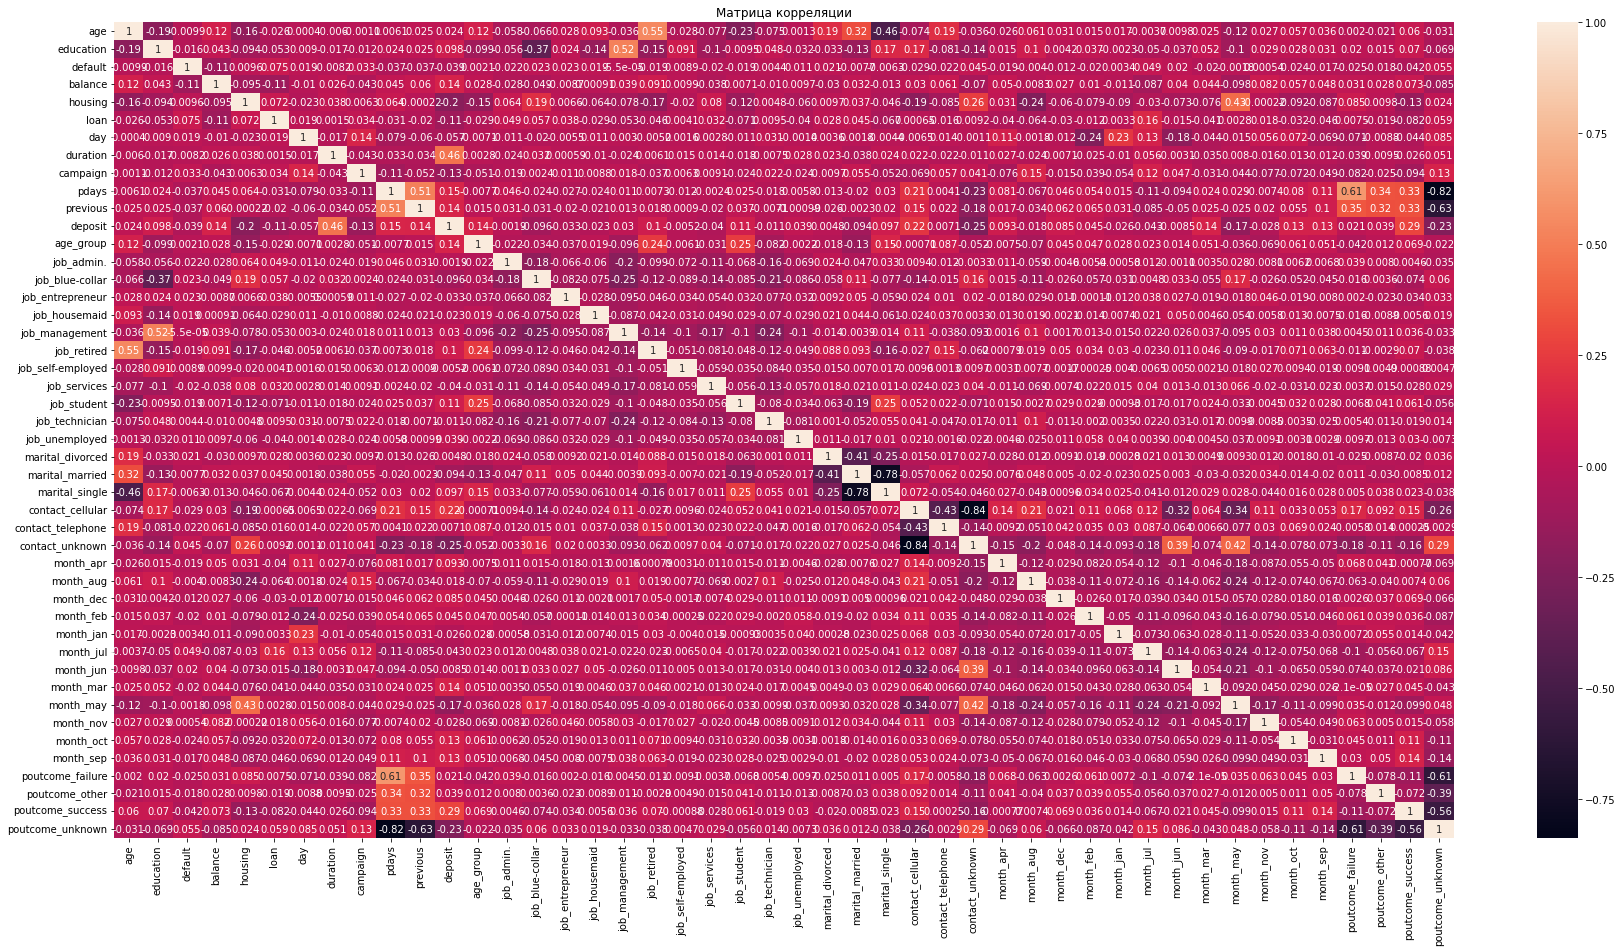

In [703]:
fig, ax = plt.subplots(figsize=(30,15))
plt.title('Матрица корреляции')
ax = sns.heatmap(df.corr(), annot=True)

Не наблюдается сильной корреляции ни у одного признака с целевой переменной 'deposit'

### Задания 7 и 8

In [704]:
df = df.select_dtypes(exclude='object') # откидываем все нечисловые признаки
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int64  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_group          10105 non-null  int64  
 13  job_admin.         10105 non-null  uint8  
 14  job_blue-collar    10105 non-null  uint8  
 15  job_entrepreneur   10105 non-null  uint8  
 16  job_housemaid      101

In [705]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [706]:
# рассчитайте необходимые показатели
print(f'В тестовой выброке получилось {X_test.shape[0]} строк') 

В тестовой выброке получилось 3335 строк


In [707]:
print(f'Среднее значение целевой переменной для тестовой выборки - {round(y_test.mean(), 2)}')

Среднее значение целевой переменной для тестовой выборки - 0.46


### Задание 9

In [708]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [709]:
select_feature = selector.get_feature_names_out().tolist()
X = df[select_feature]
#X = df1.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
#X_train = X_train[select_feature]
#X_test = X_test[select_feature]

### Задание 10

In [710]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
name_columns = X_train.columns
X_train_scal = scaler.transform(X_train)
X_test_scal = scaler.transform(X_test)
X_train = pd.DataFrame(X_train_scal, columns=name_columns)
X_test = pd.DataFrame(X_test_scal, columns=name_columns)

In [711]:
# Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из тестовой выборки. Ответ округлите до двух знаков после точки-разделителя.
round(X_test['balance'].mean(), 2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [712]:
# обучите логистическую регрессию и рассчитайте метрики качества
logreg = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
logreg.fit(X_train, y_train)
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)
print(f"accuracy на тестовом наборе: {round(metrics.accuracy_score(y_test, y_test_pred), 3)}")

accuracy на тестовом наборе: 0.805


### Задания 2,3,4

In [713]:
# обучите решающие деревья, настройте максимальную глубину
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)
#Обучаем дерево по алгоритму CART
dt.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train)
print('Train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
y_test_pred = dt.predict(X_test)
print('Test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.75


При параметрах по умолчанию, модель явно переобучена, т.к. метрика на обучающей выборке равна 1

In [714]:
# попробуем подобрать глубину дерева, чтобы избежать переобучения
for i in range(2, 10):
    dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=i,
    random_state=42
        )
    #Обучаем дерево
    dt.fit(X_train, y_train)
    #Выводим значения метрики 
    y_train_pred = dt.predict(X_train)
    print(f'Глубина дерева - {i}')
    print('Train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
    y_test_pred = dt.predict(X_test)
    print('Test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Глубина дерева - 2
Train: 0.73
Test: 0.72
Глубина дерева - 3
Train: 0.78
Test: 0.77
Глубина дерева - 4
Train: 0.78
Test: 0.77
Глубина дерева - 5
Train: 0.80
Test: 0.79
Глубина дерева - 6
Train: 0.82
Test: 0.81
Глубина дерева - 7
Train: 0.84
Test: 0.82
Глубина дерева - 8
Train: 0.84
Test: 0.81
Глубина дерева - 9
Train: 0.85
Test: 0.81


При глубине дерева 6, разница метрик для тестовой и обучающей выборки составляет 0.1, для глубины 7 - разница уже 0.2

### Задание 5

In [715]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = {'min_samples_split': [2, 5, 7, 10], #алгоритм оптимизации
              'max_depth':[3,5,7],
              'criterion':['entropy', 'gini']}
grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
        random_state=42 #генератор случайных чисел
    ), 
    param_grid=param_grid,
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train) 
y_test_pred = grid_search.predict(X_test)
print('accuracy на тестовом наборе: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: user 176 ms, sys: 75.2 ms, total: 251 ms
Wall time: 3.17 s
accuracy на тестовом наборе: 0.814
f1_score на тестовом наборе: 0.802
Наилучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 2}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [716]:
# обучите на ваших данных случайный лес
rf_clf = ensemble.RandomForestClassifier(
    n_estimators=100, #число деревьев
    criterion='gini', #критерий эффективности
    max_depth=10, #максимальная глубина дерева
    min_samples_leaf=5, # минимальное число обьектов в листе
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf.fit(X_train, y_train)

#Делаем предсказание класса
y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)
#Выводим отчет о метриках
print('accuracy на тестовом наборе: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('recall на тестовом наборе: {:.3f}'.format(metrics.recall_score(y_test, y_test_pred)))
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print(metrics.classification_report(y_test, y_test_pred))

accuracy на тестовом наборе: 0.828
recall на тестовом наборе: 0.835
f1_score на тестовом наборе: 0.819
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [717]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05, #темп обучения
    n_estimators=100, #число деревьев
    max_depth=5, #максимальная глубина дерева
    random_state=42, #генератор случайных чисел
    min_samples_leaf = 5 # минимальное количество элементов в листе
)
gb.fit(X_train, y_train)
y_pred_test = gb.predict(X_test)
print('accuracy на тестовом наборе: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('recall на тестовом наборе: {:.3f}'.format(metrics.recall_score(y_test, y_test_pred)))
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print(metrics.classification_report(y_test, y_test_pred))

accuracy на тестовом наборе: 0.828
recall на тестовом наборе: 0.835
f1_score на тестовом наборе: 0.819
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Модели дают одинаковый результат по метрикам, но случайный лес работает быстрее

### Задание 4

In [718]:
# объедините уже известные вам алгоритмы с помощью стекинга 
#Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('dt', tree.DecisionTreeClassifier(
                criterion='gini', # возьмем параметры, которые получили ранее методом GSCV
                max_depth=7, 
                min_samples_split=2, 
                random_state=42)), 
    ('lr', linear_model.LogisticRegression(random_state=42, solver='sag')),
    ('gb', ensemble.GradientBoostingClassifier(
                learning_rate=0.05, #темп обучения
                n_estimators=100, #число деревьев
                max_depth=5, #максимальная глубина дерева
                random_state=42, #генератор случайных чисел
                min_samples_leaf = 5)) # минимальное количество элементов в листе
]

#Создаем объект класса стекинг
stack_class = ensemble.StackingClassifier(
    estimators=estimators,
    #final_estimator=linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
#Обучаем модель
stack_class.fit(X_train, y_train)
y_pred_test = stack_class.predict(X_test)
print(f'Метрика precision для стекинга {round(metrics.precision_score(y_test, y_pred_test),3)}')

Метрика precision для стекинга 0.808


### Задание 5

In [719]:
from sklearn.feature_selection import RFE

In [720]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
estimator = ensemble.GradientBoostingClassifier(learning_rate=0.05, n_estimators=100, max_depth=5, random_state=42, min_samples_leaf = 5)
selector = RFE(estimator, n_features_to_select=3)
selector = selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['duration', 'contact_unknown', 'poutcome_success'], dtype=object)

### Задания 6,7,8

In [721]:
import optuna

In [733]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
  random_state = 42
  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [734]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-02-11 15:48:29,710] A new study created in memory with name: RandomForestClassifier
[I 2023-02-11 15:48:30,830] Trial 0 finished with value: 0.8534792806880376 and parameters: {'n_estimators': 181, 'max_depth': 24, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8534792806880376.
[I 2023-02-11 15:48:32,062] Trial 1 finished with value: 0.8719072972126526 and parameters: {'n_estimators': 195, 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8719072972126526.
[I 2023-02-11 15:48:33,661] Trial 2 finished with value: 0.8877072255239287 and parameters: {'n_estimators': 168, 'max_depth': 18, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.8877072255239287.
[I 2023-02-11 15:48:34,601] Trial 3 finished with value: 0.8782540919719407 and parameters: {'n_estimators': 160, 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.8877072255239287.
[I 2023-02-11 15:48:35,606] Trial 4 finished with value: 0.8766567908934976 and parameters: {'n_

CPU times: user 15.2 s, sys: 335 ms, total: 15.6 s
Wall time: 17 s


In [735]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 145, 'max_depth': 26, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92


In [736]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.5f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.5f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.82579
f1_score на тестовом наборе: 0.81712
